In [2]:
# Core imports
import os
import os.path as op
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import warnings
warnings.filterwarnings('ignore')

# Nilearn imports
from nilearn import image, plotting
from nilearn.glm.first_level import FirstLevelModel, make_first_level_design_matrix
from nilearn.image import clean_img
from nilearn.plotting import plot_design_matrix, plot_stat_map, plot_glass_brain
from nilearn.maskers import NiftiMasker
import nilearn.interfaces.fmriprep

# ML imports
from sklearn.model_selection import cross_val_score, LeaveOneGroupOut, cross_val_predict
from sklearn.svm import SVC, LinearSVC
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

# Set random seed
np.random.seed(42)

# Plotting style
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_context('notebook')
%matplotlib inline

print("Imports successful!")

Imports successful!


---

# 1. Dataset Organization

In [ ]:
# Configure paths - ADJUST TO YOUR SYSTEM
BASE_PATH = Path('/home/hyruuk/DATA/neuromod/mario_data')

# Directories
MARIO_PATH = BASE_PATH / 'mario'
FMRIPREP_PATH = BASE_PATH / 'mario.fmriprep'
ANNOTATIONS_PATH = BASE_PATH / 'mario.annotations' / 'outputdata' / 'annotated_events'

# Parameters
SUBJECT = 'sub-01'
SESSION = 'ses-001'
RUN = '01'
TR = 1.49  # seconds

# File paths
func_dir = FMRIPREP_PATH / SUBJECT / SESSION / 'func'
bold_file = func_dir / f'{SUBJECT}_{SESSION}_task-mario_run-{RUN}_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz'
mask_file = func_dir / f'{SUBJECT}_{SESSION}_task-mario_run-{RUN}_space-MNI152NLin2009cAsym_desc-brain_mask.nii.gz'
confounds_file = func_dir / f'{SUBJECT}_{SESSION}_task-mario_run-{RUN}_desc-confounds_timeseries.tsv'
events_file = ANNOTATIONS_PATH / SUBJECT / SESSION / 'func' / f'{SUBJECT}_{SESSION}_task-mario_run-{RUN}_desc-annotated_events.tsv'

print(f"Dataset: {SUBJECT} / {SESSION} / run-{RUN}")
print(f"\nFile checks:")
print(f"  BOLD: {bold_file.exists()}")
print(f"  Mask: {mask_file.exists()}")
print(f"  Confounds: {confounds_file.exists()}")
print(f"  Events: {events_file.exists()}")

Dataset: sub-01 / ses-001 / run-01

File checks:
  BOLD: False
  Mask: False
  Confounds: False
  Events: True


### Dataset Structure

- **`mario/`**: Raw BIDS data with basic events (repetition onsets)
- **`mario.fmriprep/`**: Preprocessed BOLD in MNI space, confounds, masks
- **`mario.annotations/`**: Rich behavioral annotations:
  - **Actions**: A (jump), B (run/fire), LEFT, RIGHT, UP, DOWN
  - **Game events**: Kill/stomp, Kill/impact, Kill/kick, Hit/life_lost, Hit/powerup_lost, Coin_collected, Powerup_collected, Brick_smashed
  - **Scenes**: Level segments (w{world}l{level}s{scene})
  - **Repetitions**: gym-retro_game (one level attempt)

---

# 2. Loading and Exploring Annotations

In [4]:
# Load annotated events
events = pd.read_csv(events_file, sep='\t')

print(f"Events shape: {events.shape}")
print(f"\nColumns: {list(events.columns)}")
print(f"\nEvent type summary:")

# Categorize events
actions = ['A', 'B', 'LEFT', 'RIGHT', 'UP', 'DOWN']
game_events = ['Kill/stomp', 'Kill/impact', 'Kill/kick', 
               'Hit/life_lost', 'Hit/powerup_lost',
               'Coin_collected', 'Powerup_collected', 'Brick_smashed']

action_count = events['trial_type'].isin(actions).sum()
event_count = events['trial_type'].isin(game_events).sum()
scene_count = events['trial_type'].str.contains('scene-', na=False).sum()
rep_count = (events['trial_type'] == 'gym-retro_game').sum()

print(f"  Actions: {action_count}")
print(f"  Game events: {event_count}")
print(f"  Scene transitions: {scene_count}")
print(f"  Repetitions: {rep_count}")

display(events.head(15))

Events shape: (888, 9)

Columns: ['rep_index', 'trial_type', 'onset', 'level', 'stim_file', 'frame_start', 'frame_stop', 'duration', 'phase']

Event type summary:
  Actions: 620
  Game events: 81
  Scene transitions: 176
  Repetitions: 11


,rep_index,trial_type,onset,level,stim_file,frame_start,frame_stop,duration,phase
0,0.0,gym-retro_game,0.012522,w1l1,sub-01/ses-001/gamelogs/sub-01_ses-001_task-ma...,0.0,4831.0,80.516667,discovery
1,NaN,scene-w1l1s0_code-00101000000122,2.045855,w1l1,NaN,122.0,578.0,7.600000,NaN
2,NaN,RIGHT,2.745522,w1l1,NaN,164.0,186.0,0.367000,NaN
3,NaN,RIGHT,3.729522,w1l1,NaN,223.0,265.0,0.700000,NaN
4,NaN,LEFT,4.679522,w1l1,NaN,280.0,323.0,0.716000,NaN
5,NaN,RIGHT,5.729522,w1l1,NaN,343.0,407.0,1.066000,NaN
6,NaN,B,5.795522,w1l1,NaN,347.0,410.0,1.050000,NaN
7,NaN,LEFT,6.929522,w1l1,NaN,415.0,458.0,0.716000,NaN
8,NaN,B,7.795522,w1l1,NaN,467.0,484.0,0.284000,NaN
9,NaN,RIGHT,7.845522,w1l1,NaN,470.0,478.0,0.134000,NaN


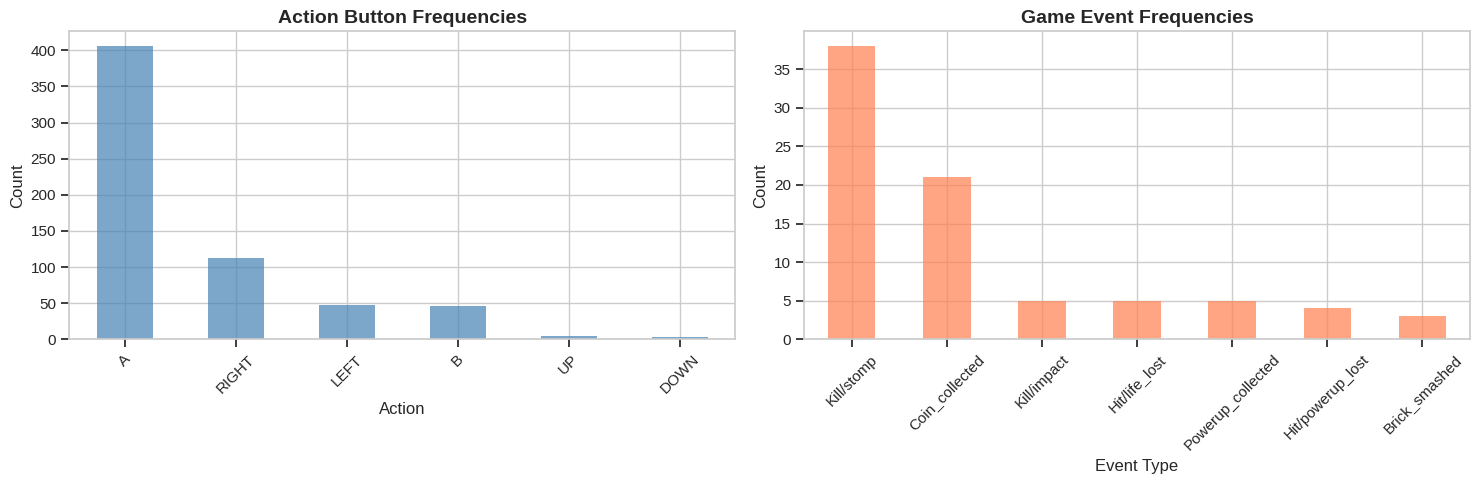


Action breakdown:
  A: 406
  B: 46
  LEFT: 48
  RIGHT: 112
  UP: 5
  DOWN: 3

Game event breakdown:
  Kill/stomp: 38
  Kill/impact: 5
  Hit/life_lost: 5
  Hit/powerup_lost: 4
  Coin_collected: 21
  Powerup_collected: 5
  Brick_smashed: 3


In [5]:
# Visualize event frequencies
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Actions
action_counts = events[events['trial_type'].isin(actions)]['trial_type'].value_counts()
action_counts.plot(kind='bar', ax=axes[0], color='steelblue', alpha=0.7)
axes[0].set_title('Action Button Frequencies', fontsize=14, weight='bold')
axes[0].set_ylabel('Count')
axes[0].set_xlabel('Action')
axes[0].tick_params(axis='x', rotation=45)

# Game events
event_counts = events[events['trial_type'].isin(game_events)]['trial_type'].value_counts()
event_counts.plot(kind='bar', ax=axes[1], color='coral', alpha=0.7)
axes[1].set_title('Game Event Frequencies', fontsize=14, weight='bold')
axes[1].set_ylabel('Count')
axes[1].set_xlabel('Event Type')
axes[1].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

print(f"\nAction breakdown:")
for action in actions:
    count = (events['trial_type'] == action).sum()
    print(f"  {action}: {count}")

print(f"\nGame event breakdown:")
for event in game_events:
    count = (events['trial_type'] == event).sum()
    if count > 0:
        print(f"  {event}: {count}")

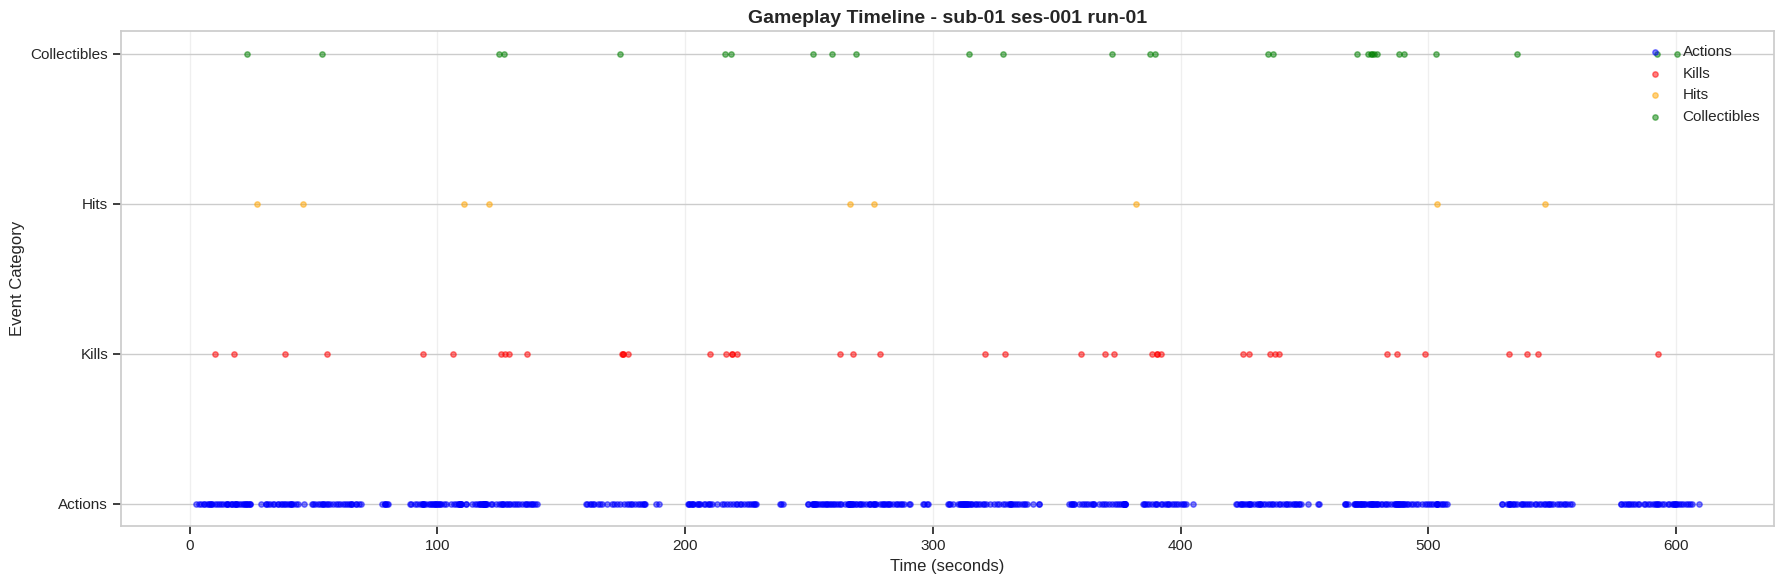

In [6]:
# Timeline visualization
fig, ax = plt.subplots(figsize=(18, 6))

event_categories = {
    'Actions': actions,
    'Kills': ['Kill/stomp', 'Kill/impact', 'Kill/kick'],
    'Hits': ['Hit/life_lost', 'Hit/powerup_lost'],
    'Collectibles': ['Coin_collected', 'Powerup_collected', 'Brick_smashed']
}

colors = {'Actions': 'blue', 'Kills': 'red', 'Hits': 'orange', 'Collectibles': 'green'}

y_pos = 0
for category, event_list in event_categories.items():
    cat_events = events[events['trial_type'].isin(event_list)]
    if len(cat_events) > 0:
        ax.scatter(cat_events['onset'], [y_pos] * len(cat_events),
                  alpha=0.5, s=15, label=category, color=colors[category])
        y_pos += 1

ax.set_xlabel('Time (seconds)', fontsize=12)
ax.set_ylabel('Event Category', fontsize=12)
ax.set_title(f'Gameplay Timeline - {SUBJECT} {SESSION} run-{RUN}', fontsize=14, weight='bold')
ax.legend(loc='upper right')
ax.set_yticks(range(len(event_categories)))
ax.set_yticklabels(event_categories.keys())
ax.grid(True, alpha=0.3, axis='x')
plt.tight_layout()
plt.show()

---

# 3. GLM Analysis - Linking Annotations to BOLD

## 3.1 Load Confounds

In [7]:
def load_confounds_mario(bold_file, events_df, t_r=1.49):
    """
    Load fMRIPrep confounds following Shinobi analysis strategy.
    Adds button press count as additional confound.
    """
    # Load confounds: motion (24 params), high-pass, WM/CSF, global signal
    confounds_tuple = nilearn.interfaces.fmriprep.load_confounds(
        str(bold_file),
        strategy=("motion", "high_pass", "wm_csf"),
        motion="full",
        wm_csf="basic",
        global_signal="full",
    )
    
    confounds_df = confounds_tuple[0]
    n_volumes = len(confounds_df)
    
    # Add button press confound
    button_columns = ['A', 'B', 'LEFT', 'RIGHT', 'UP', 'DOWN']
    action_events = events_df[events_df['trial_type'].isin(button_columns)]
    
    button_count = np.zeros(n_volumes)
    for _, event in action_events.iterrows():
        vol_idx = int(np.round(event['onset'] / t_r))
        if 0 <= vol_idx < n_volumes:
            button_count[vol_idx] += 1
    
    confounds_df['button_count_press'] = button_count
    
    return confounds_df

# Load confounds
confounds = load_confounds_mario(bold_file, events, TR)
print(f"Confounds shape: {confounds.shape}")
print(f"Confounds: {list(confounds.columns[:10])}... (+{len(confounds.columns)-10} more)")

ValueError: Could not find associated confound file. The functional derivatives should exist under the same parent directory.

## 3.2 Create Design Matrices

We'll create separate models:
1. **Actions model**: Button presses only
2. **Events model**: Game events only (kills, hits, collectibles)
3. **Full model**: Actions + Events

In [ ]:
# Load BOLD image
bold_img = image.load_img(bold_file)
n_scans = bold_img.shape[-1]
frame_times = np.arange(n_scans) * TR

print(f"BOLD shape: {bold_img.shape}")
print(f"Number of volumes: {n_scans}")
print(f"Duration: {n_scans * TR:.1f}s ({n_scans * TR / 60:.1f} min)")

In [ ]:
# Design matrix for ACTIONS
actions_events = events[events['trial_type'].isin(actions)][['trial_type', 'onset', 'duration']].copy()

design_actions = make_first_level_design_matrix(
    frame_times,
    events=actions_events,
    hrf_model='spm',
    drift_model=None,
    add_regs=confounds,
    add_reg_names=list(confounds.columns)
)

print(f"Actions design matrix shape: {design_actions.shape}")
print(f"Action regressors: {[c for c in design_actions.columns if c in actions]}")

# Visualize
fig, ax = plt.subplots(figsize=(10, 8))
plot_design_matrix(design_actions, ax=ax)
ax.set_title('Design Matrix - Actions Model', fontsize=14, weight='bold')
plt.tight_layout()
plt.show()

In [ ]:
# Design matrix for GAME EVENTS
game_events_df = events[events['trial_type'].isin(game_events)][['trial_type', 'onset', 'duration']].copy()

if len(game_events_df) > 0:
    design_events = make_first_level_design_matrix(
        frame_times,
        events=game_events_df,
        hrf_model='spm',
        drift_model=None,
        add_regs=confounds,
        add_reg_names=list(confounds.columns)
    )
    
    print(f"Events design matrix shape: {design_events.shape}")
    print(f"Event regressors: {[c for c in design_events.columns if c in game_events]}")
else:
    print("No game events found in this run.")
    design_events = None

## 3.3 Fit GLM Models

In [ ]:
# Load mask
mask_img = image.load_img(mask_file)

# Fit ACTIONS GLM
print("Fitting Actions GLM...")
glm_actions = FirstLevelModel(
    t_r=TR,
    noise_model='ar1',
    standardize=False,
    hrf_model='spm',
    drift_model=None,
    high_pass=None,
    smoothing_fwhm=5,
    mask_img=mask_img,
    minimize_memory=False
)

glm_actions = glm_actions.fit(bold_img, design_matrices=design_actions)
print("Actions GLM fitted!")

In [ ]:
# Fit EVENTS GLM (if events exist)
if design_events is not None:
    print("Fitting Events GLM...")
    glm_events = FirstLevelModel(
        t_r=TR,
        noise_model='ar1',
        standardize=False,
        hrf_model='spm',
        drift_model=None,
        high_pass=None,
        smoothing_fwhm=5,
        mask_img=mask_img,
        minimize_memory=False
    )
    
    glm_events = glm_events.fit(bold_img, design_matrices=design_events)
    print("Events GLM fitted!")

## 3.4 Compute and Visualize Contrasts

In [ ]:
# Example contrasts for actions
contrasts_to_plot = []

# Individual actions
for action in ['A', 'LEFT', 'RIGHT']:
    if action in design_actions.columns:
        z_map = glm_actions.compute_contrast(action, output_type='z_score')
        contrasts_to_plot.append((action, z_map))

# Motor contrast (LEFT + RIGHT)
if 'LEFT' in design_actions.columns and 'RIGHT' in design_actions.columns:
    z_map_motor = glm_actions.compute_contrast(
        {'LEFT': 1, 'RIGHT': 1},
        output_type='z_score',
        stat_type='F'
    )
    contrasts_to_plot.append(('Motor (LEFT+RIGHT)', z_map_motor))

# Plot contrasts
for name, z_map in contrasts_to_plot:
    fig, axes = plt.subplots(2, 1, figsize=(14, 8))
    
    plotting.plot_glass_brain(
        z_map,
        threshold=3.1,
        colorbar=True,
        title=f'{name} - Glass Brain',
        axes=axes[0]
    )
    
    plotting.plot_stat_map(
        z_map,
        threshold=3.1,
        display_mode='z',
        cut_coords=6,
        title=f'{name} - Axial Slices',
        axes=axes[1]
    )
    
    plt.tight_layout()
    plt.show()

In [ ]:
# Event contrasts (if available)
if design_events is not None:
    for event in ['Kill/stomp', 'Hit/life_lost']:
        if event in design_events.columns:
            z_map = glm_events.compute_contrast(event, output_type='z_score')
            
            plotting.plot_glass_brain(
                z_map,
                threshold=3.1,
                colorbar=True,
                title=f'{event} - Glass Brain'
            )
            plt.show()

---

# 4. MVPA - Action Classification

We'll classify LEFT vs RIGHT button presses using voxel-wise patterns.

## 4.1 Extract Trial-wise Beta Maps using LSS

Least Squares Separate (LSS): Estimate each trial separately.

In [ ]:
def extract_trial_betas_lss(bold_img, events_df, confounds_df, mask_img, 
                            target_events, t_r=1.49):
    """
    Extract trial-wise beta maps using LSS approach.
    
    Parameters
    ----------
    bold_img : Nifti image
        BOLD data
    events_df : DataFrame
        All events
    confounds_df : DataFrame
        Confound regressors
    mask_img : Nifti image
        Brain mask
    target_events : list
        Event types to extract (e.g., ['LEFT', 'RIGHT'])
    t_r : float
        TR in seconds
    
    Returns
    -------
    beta_maps : list of Nifti images
        One beta map per trial
    labels : list
        Event type for each trial
    """
    # Filter events
    target_trials = events_df[events_df['trial_type'].isin(target_events)].copy().reset_index(drop=True)
    n_trials = len(target_trials)
    
    print(f"Extracting beta maps for {n_trials} trials using LSS...")
    
    beta_maps = []
    labels = []
    
    n_scans = bold_img.shape[-1]
    frame_times = np.arange(n_scans) * t_r
    
    # LSS: Fit separate GLM for each trial
    for trial_idx in range(n_trials):
        if trial_idx % 10 == 0:
            print(f"  Processing trial {trial_idx+1}/{n_trials}...")
        
        # Create events for this LSS model
        # - Target trial gets its own regressor
        # - All other trials pooled into one regressor
        trial_event = target_trials.iloc[[trial_idx]][['trial_type', 'onset', 'duration']].copy()
        trial_event['trial_type'] = 'target_trial'
        
        other_events = target_trials.drop(trial_idx)[['trial_type', 'onset', 'duration']].copy()
        other_events['trial_type'] = 'other_trials'
        
        lss_events = pd.concat([trial_event, other_events], ignore_index=True)
        
        # Create design matrix
        design = make_first_level_design_matrix(
            frame_times,
            events=lss_events,
            hrf_model='spm',
            drift_model=None,
            add_regs=confounds_df,
            add_reg_names=list(confounds_df.columns)
        )
        
        # Fit GLM
        glm = FirstLevelModel(
            t_r=t_r,
            noise_model='ar1',
            standardize=False,
            hrf_model='spm',
            drift_model=None,
            high_pass=None,
            mask_img=mask_img,
            minimize_memory=True
        )
        glm.fit(bold_img, design_matrices=design)
        
        # Extract beta for target trial
        beta = glm.compute_contrast('target_trial', output_type='effect_size')
        beta_maps.append(beta)
        labels.append(target_trials.iloc[trial_idx]['trial_type'])
    
    print(f"Extracted {len(beta_maps)} beta maps!")
    return beta_maps, labels

In [ ]:
# Extract betas for LEFT vs RIGHT classification
target_actions = ['LEFT', 'RIGHT']

beta_maps, trial_labels = extract_trial_betas_lss(
    bold_img, 
    events, 
    confounds, 
    mask_img,
    target_actions,
    t_r=TR
)

print(f"\nTrial distribution:")
for label in target_actions:
    count = trial_labels.count(label)
    print(f"  {label}: {count} trials")

## 4.2 Prepare Data for Classification

In [ ]:
# Extract voxel patterns using NiftiMasker
masker = NiftiMasker(mask_img=mask_img, standardize=True)
masker.fit()

# Transform beta maps to voxel patterns
X = masker.transform(beta_maps)
y = np.array(trial_labels)

print(f"Feature matrix shape: {X.shape}")
print(f"  {X.shape[0]} trials")
print(f"  {X.shape[1]} voxels")
print(f"\nLabels: {np.unique(y)}")

## 4.3 Train and Evaluate Classifier

In [ ]:
# Build classification pipeline
classifier = Pipeline([
    ('scaler', StandardScaler()),
    ('svm', LinearSVC(C=1.0, max_iter=10000, dual=False))
])

# Leave-one-out cross-validation
from sklearn.model_selection import LeaveOneOut
loo = LeaveOneOut()

# Cross-validated predictions
y_pred = cross_val_predict(classifier, X, y, cv=loo)

# Accuracy
accuracy = accuracy_score(y, y_pred)
print(f"Classification Accuracy: {accuracy:.2%}")
print(f"Chance level: {1/len(np.unique(y)):.2%}")

# Classification report
print("\nClassification Report:")
print(classification_report(y, y_pred))

# Confusion matrix
cm = confusion_matrix(y, y_pred, labels=target_actions)
fig, ax = plt.subplots(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=target_actions, yticklabels=target_actions,
            ax=ax, cbar_kws={'label': 'Count'})
ax.set_xlabel('Predicted')
ax.set_ylabel('True')
ax.set_title(f'Confusion Matrix - LEFT vs RIGHT\nAccuracy: {accuracy:.2%}', weight='bold')
plt.tight_layout()
plt.show()

In [ ]:
# Feature importance: train on all data and visualize weights
classifier.fit(X, y)
weights = classifier.named_steps['svm'].coef_[0]

# Create weight map
weight_map = masker.inverse_transform(weights)

# Visualize
plotting.plot_stat_map(
    weight_map,
    threshold=np.percentile(np.abs(weights), 95),
    display_mode='z',
    cut_coords=8,
    title='SVM Weights: LEFT vs RIGHT Classification',
    colorbar=True
)
plt.show()

---

# 5. RL Encoding Model

We'll create a simple encoding model using reward-related variables:
- **Player X position** (progress through level)
- **Time** (time pressure)
- **Lives** (risk/value)

## 5.1 Extract RL Variables from Events

**Note**: Full RL agent training is computationally intensive. For this tutorial, we'll use simple proxy variables from the annotations.

In [ ]:
# PLACEHOLDER: RL variable extraction
# This would require:
# 1. Loading .bk2 replay files with gym-retro
# 2. Extracting frame-by-frame RAM states (player position, lives, time)
# 3. Downsampling to TR
#
# For now, we'll create proxy variables from events

def create_rl_regressors(events_df, n_volumes, t_r=1.49):
    """
    Create reward-related regressors from game events.
    
    Returns
    -------
    rl_regressors : DataFrame
        Regressors: reward_rate, punishment_rate
    """
    # Initialize
    reward_events = np.zeros(n_volumes)
    punishment_events = np.zeros(n_volumes)
    
    # Map events to volumes
    for _, event in events_df.iterrows():
        vol_idx = int(np.round(event['onset'] / t_r))
        if 0 <= vol_idx < n_volumes:
            # Rewards
            if event['trial_type'] in ['Kill/stomp', 'Kill/impact', 'Kill/kick', 
                                       'Coin_collected', 'Powerup_collected']:
                reward_events[vol_idx] += 1
            # Punishments
            elif event['trial_type'] in ['Hit/life_lost', 'Hit/powerup_lost']:
                punishment_events[vol_idx] += 1
    
    # Smooth to create continuous signal (simple moving average)
    window = int(5 / t_r)  # 5-second window
    reward_rate = np.convolve(reward_events, np.ones(window)/window, mode='same')
    punishment_rate = np.convolve(punishment_events, np.ones(window)/window, mode='same')
    
    rl_df = pd.DataFrame({
        'reward_rate': reward_rate,
        'punishment_rate': punishment_rate,
    })
    
    return rl_df

# Create RL regressors
rl_regressors = create_rl_regressors(events, n_scans, TR)

print(f"RL regressors shape: {rl_regressors.shape}")
print(f"Columns: {list(rl_regressors.columns)}")

# Visualize
fig, axes = plt.subplots(2, 1, figsize=(14, 6), sharex=True)
time_axis = np.arange(n_scans) * TR

axes[0].plot(time_axis, rl_regressors['reward_rate'], color='green', linewidth=2)
axes[0].set_ylabel('Reward Rate')
axes[0].set_title('Reward Events (smoothed)', weight='bold')
axes[0].grid(True, alpha=0.3)

axes[1].plot(time_axis, rl_regressors['punishment_rate'], color='red', linewidth=2)
axes[1].set_ylabel('Punishment Rate')
axes[1].set_xlabel('Time (seconds)')
axes[1].set_title('Punishment Events (smoothed)', weight='bold')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## 5.2 RL Encoding GLM

Fit a GLM with RL variables as parametric regressors.

In [ ]:
# Combine confounds with RL regressors
confounds_rl = pd.concat([confounds, rl_regressors], axis=1)

# Create design matrix (no events, just RL regressors)
design_rl = make_first_level_design_matrix(
    frame_times,
    events=None,
    hrf_model=None,  # RL variables are already in BOLD space
    drift_model=None,
    add_regs=confounds_rl,
    add_reg_names=list(confounds_rl.columns)
)

print(f"RL design matrix shape: {design_rl.shape}")

# Fit GLM
print("Fitting RL encoding GLM...")
glm_rl = FirstLevelModel(
    t_r=TR,
    noise_model='ar1',
    standardize=False,
    hrf_model=None,
    drift_model=None,
    high_pass=None,
    smoothing_fwhm=5,
    mask_img=mask_img,
    minimize_memory=False
)

glm_rl = glm_rl.fit(bold_img, design_matrices=design_rl)
print("RL GLM fitted!")

## 5.3 Visualize RL Encoding Results

In [ ]:
# Compute contrasts for RL variables
for rl_var in ['reward_rate', 'punishment_rate']:
    z_map = glm_rl.compute_contrast(rl_var, output_type='z_score')
    
    fig, axes = plt.subplots(2, 1, figsize=(14, 8))
    
    plotting.plot_glass_brain(
        z_map,
        threshold=2.3,
        colorbar=True,
        title=f'{rl_var.replace("_", " ").title()} - Glass Brain',
        axes=axes[0]
    )
    
    plotting.plot_stat_map(
        z_map,
        threshold=2.3,
        display_mode='z',
        cut_coords=6,
        title=f'{rl_var.replace("_", " ").title()} - Axial Slices',
        axes=axes[1]
    )
    
    plt.tight_layout()
    plt.show()

## 5.4 PLACEHOLDER: Full RL Agent Implementation

**For a complete RL encoding model, you would:**

1. **Train RL agent** (PPO with 4-layer CNN)
   - Environment: `gym-retro` with SuperMarioBros-Nes
   - Training: ~1M-10M steps (several hours on laptop)
   - Alternative: Use pre-trained agent or simpler algorithm (DQN)

2. **Extract RL variables during human gameplay**
   - Load .bk2 replay files
   - Feed frames through agent
   - Extract: player_x_pos, time_left, lives, value estimates V(s)
   - Compute RPE: δ = r + γV(s') - V(s)

3. **Downsample to TR and create regressors**
   - Bin variables to match fMRI volumes
   - Optionally convolve with HRF

4. **Model comparison**
   - Compare nested models with F-tests
   - Baseline: motion + nuisance only
   - +Actions: add button presses
   - +RL: add reward/punishment
   - +Full: actions + RL variables

**Training estimate**: A simple PPO agent might need:
- ~500K-1M steps to learn basic gameplay
- ~2-4 hours on laptop with GPU
- ~8-12 hours on laptop CPU-only

**Would you like me to implement the full RL training pipeline?**

---

# Summary

## What We Accomplished

✅ **Dataset exploration** - Understood BIDS structure and derivatives

✅ **Annotations** - Loaded and visualized behavioral events from mario.annotations

✅ **GLM analysis** - Fitted models for actions and game events with proper confounds

✅ **MVPA** - Classified LEFT vs RIGHT button presses using voxel-wise patterns (LSS approach)

✅ **RL encoding** - Created reward-based regressors and fitted encoding model

## Next Steps

1. **Expand to multiple runs/sessions** - Increase statistical power
2. **Scene-level analyses** - Model scene transitions (requires multiple sessions)
3. **Searchlight MVPA** - Localize information content spatially
4. **Full RL agent** - Train PPO agent for more sophisticated encoding models
5. **Group-level analysis** - Combine subjects for population inferences

## Questions?

- Which analyses should be expanded?
- Should we implement full RL agent training?
- Any specific contrasts or comparisons of interest?